# Generalized GMM

# This code is an extension of a class assignment. It involves generating Univariate Gaussian mixtures and then clustering them to get the approximate Gaussian mixtures generated by calculating their Mean, Standard Deviation and mixing ratios.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import scipy
%matplotlib inline

In [4]:
sns.set(color_codes=True)

In [8]:
class GMM():
    
    _synthetic = {
        'mean': [],
        'sds': [],
        'mixing_ratio': []
    }
    
    def random_spaced(self, low, high, delta, n, size=None):
        """
        Choose n random values between low and high, with minimum spacing delta.

        If size is None, one sample is returned.
        Set size=m (an integer) to return m samples.

        The values in each sample returned by random_spaced are in increasing
        order.
        """
        empty_space = high - low - (n-1)*delta
        if empty_space < 0:
            raise ValueError("not possible")

        if size is None:
            u = np.random.rand(n)
        else:
            u = np.random.rand(size, n)
        x = empty_space * np.sort(u, axis=-1)
        return low + x + delta * np.arange(n)
    
    def get_data(self, n_mixtures, samples_pm, mean_rng, sd_rng):
        """
        Produce n_mixtures Gaussian mixtures with means and sds between
        mean_rng & sd_rng respectively.

        bins provides the mixing ratio for each of the n_mixtures.

        Returns a numpy vector X containing values sampled from n_mixtures
        Gausssians with the given mixing ratios.
        """
        diri = np.random.dirichlet(np.ones(n_mixtures),size=1).flatten()
        bins = np.round(np.append(np.append([0],np.sort(np.random.choice(diri, len(diri) -1, replace=False))).flatten(), [1]).flatten(), 2)
        means = np.round(self.random_spaced(low=mean_rng[0], high=mean_rng[1], delta=100, n=n_mixtures), 2) 
        sds = np.round(self.random_spaced(low=sd_rng[0], high=sd_rng[1], delta=1, n=n_mixtures), 2)
        mx = np.diff(bins)
        self._synthetic = {
            'means': means,
            'sds': sds,
            'mixing_ratio': mx
        }
        X=[]

        for _ in range(n_mixtures*samples_pm):
            ind = np.digitize(np.random.uniform(low=0, high=1), bins)
            X.append(np.random.normal(loc=means[ind-1], scale=sds[ind-1]))

        X = np.array(X)
        plt.title('Histogram of Data')
        sns.distplot(X)
        plt.show()
        print('Means: ', means)
        print('SDs: ', sds)
        print('Bins: ', bins)
        print('Mixing ratios: ', np.diff(bins))
        return X

    def info(self, w, mu, sigma, n_mixtures, c=0):
        for _ in np.argsort(mu):
            c+=1
            print('Gaussian {}:'.format(c), end='\t')
            print('w{}:{}'.format(c, np.round(w[_],2)), end='\t')
            print('Mean:{}, Standard Deviation:{}'.format(np.round(mu[_],2), np.round(sigma[_],2)))
        
    def log_like(self, w, mu, sigma, X, n_mixtures):
        try:
            val = [0]*n_mixtures
            for _ in range(n_mixtures):
                val[_] = w[_]*stats.norm.pdf(X, loc=mu[_], scale=sigma[_])
    #             print(w[_], mu[_], sigma[_], val[_])
        except:
            pass
        return np.log(np.sum(np.array(val)))

    def mutual_info(self, p):
        last_mix = p[-1]
        p_k = np.mean(last_mix)
        mi = np.array([])
    #     print('Mutual Information with previous Gaussians: ')
        for _ in p[:-1]:
            p_i = np.mean(_)
            p_ik = np.mean(np.multiply(last_mix, _))
            mi = np.append(mi, p_ik*np.log2(p_ik/(p_i*p_k)) if p_ik!=0 else 0)
    #         print(mi)
        return mi

    def plot_ll(self, ll, convergence_step):
        plt.subplot(1, 2, 2)
        plt.plot(ll)
        plt.xlabel('Steps')
        plt.ylabel('Log Likelihood')
        plt.title('All iterations')

        plt.subplot(1, 2, 1)
        plt.plot(ll[:convergence_step+10])
        plt.xlabel('Steps')
        plt.ylabel('Log Likelihood')
        plt.title('Convergence at step {}'.format(convergence_step))
        plt.tight_layout()
        
    def estimation_error(self, checkpoint):
        index_to_remove = np.where(self._synthetic['mixing_ratio']<=0)
        ms=np.delete(self._synthetic['means'], index_to_remove)
        sd=np.delete(self._synthetic['sds'], index_to_remove)
        mx=np.delete(self._synthetic['mixing_ratio'], index_to_remove)
        
        if(len(ms)!=len(checkpoint['means'])):
            print('Unable to estimate error')
            return
        
        print('\n\nEstimation error in:')
        index_sort = np.argsort(checkpoint['means'])
        ms=ms-checkpoint['means'][index_sort]
        sd=sd-checkpoint['sds'][index_sort]
        mx=mx-checkpoint['mixing_ratio'][index_sort]
        
        print('means: {}, RMSE: {}'.format(ms, np.sqrt(np.sum(ms**2))))
        print('sds: {}, RMSE: {}'.format(sd, np.sqrt(np.sum(sd**2))))
        print('mixing_ratio: {}, RMSE: {}'.format(mx, np.sqrt(np.sum(mx**2))))
        
        
    def estimate_gaussians(self, n_mixtures, samples_pm=100, mean_rng=[0, 2000], sd_rng=[1, 20]):
    
        # Initializing values
#         n_mixtures=4
#         samples_pm=100
#         mean_rng=[0, 2000]
#         sd_rng=[1, 20]
        checkpoint = {
            'n_mixtures': 1,
            'mixing_ratio': [],
            'means': [],
            'sds': [],
            'affinity': [],
            'likelihood': []
        }

        # generate synthetic data
        X = self.get_data(n_mixtures, samples_pm, mean_rng, sd_rng)

        # calculate center of first mixture
        d = scipy.spatial.distance.cdist(np.vstack(X), np.vstack(X), lambda u, v: np.exp(-((u-v)**2).sum()))
        _clusters = 1
        _cluster_centers = np.array([])
        _cluster_centers_final=np.append(_cluster_centers, X[np.argmax(np.sum(d, axis=0))])
        
        # data{[data_i, cluster]}
        data = np.hstack((np.vstack(X), np.vstack([-1]*X.shape[0])))
        
        # repeat until two estimated Gaussians are similar
        while True:
            
            E_n=[]
            _clusters+=1
            _centers_temp=[]
            
            for candidate in data[:, 0]:
                _cluster_centers=_cluster_centers_final
                _cluster_centers=np.append(_cluster_centers, candidate)
        
                #compute and update the best centroids within cluster
                while True:
                    data[:,1]=np.argmin(scipy.spatial.distance.cdist(np.vstack(data[:,0]), np.vstack(_cluster_centers)), axis=1)
                    new_centroids=pd.DataFrame(data, columns=['col1', 'col2']).groupby('col2').mean().values.flatten()
                    if all(i<1e-08 for i in (_cluster_centers-new_centroids)):
                        break
                    
                    _cluster_centers=np.array(list(map(np.mean, new_centroids)))
                
                # find optimal cluster centroids with respect to each data point
                _centers_temp.append(_cluster_centers)
                
                temp_data = data.copy()
                E_n.append(np.sum((temp_data[:,0]-_cluster_centers[data[:,1].astype(int)])**2))
                _cluster_centers = np.delete(_cluster_centers, -1)

            # choose centroids with minimum error
            _cluster_centers_final=_centers_temp[np.argmin(E_n)]
        
            # sort centroids in increasing order
            np.sort(_cluster_centers_final)
        
            print('\nCalculated means:')
            print(_cluster_centers_final)

            # GMM 
            n_mixtures=_clusters
            datapoints = np.array_split(np.array(data[:,0]), n_mixtures)

            # initialize EM algorithm
            w=[1/n_mixtures]*n_mixtures

            mu=np.array([])
            sigma=np.array([])
            f=[0]*n_mixtures

            for _ in (datapoints):
                sigma=np.append(sigma, np.std(_))

            # mu calculated from incremental k-means
            mu = _cluster_centers_final

            
            # calculate likelihood for each point belonging to a gaussian
            for _ in range(n_mixtures):
                f[_] = stats.norm.pdf(data[:, 0], loc=mu[_], scale=sigma[_])

            ll = []

            print('\nInitial Values: ')
            self.info(w, mu, sigma, n_mixtures)

            # upper limit on total number of iterations
            n_iterations = 300
            convergence_step = -1
            
            # EM Algorithm
            for _ in range(n_iterations):

                ll.append(self.log_like(w, mu, sigma, X, n_mixtures))
                
                if len(ll)>1:
                    if ((ll[-1]-ll[-2])<1e-16) & (convergence_step<0):
                        # Remember convergence step
                        convergence_step = _
                        print('\nFinal values at convergence step: ', _)
                        self.info(w, mu, sigma, n_mixtures)

                # E-step
                p_class=[0]*n_mixtures
                total=0
                for i in range(n_mixtures):
                    total+=np.multiply(w[i], f[i])
                for i in range(n_mixtures):
                    p_class[i] = np.multiply(w[i], f[i])/total

                # M-step
                for i in range(n_mixtures):
                    w[i] = np.mean(p_class[i])
                    mu[i] = np.sum(np.multiply(X, p_class[i]))/ np.sum(p_class[i])
                    sigma[i] = np.sqrt(np.sum(np.multiply((X-mu[i])**2, p_class[i]))/ np.sum(p_class[i]))
                    f[i] = stats.norm.pdf(X, loc=mu[i], scale=sigma[i])


            # update cluster centers after EM algorithm converges
            _cluster_centers_final = mu

            print('\nFinal values after all iterations: ')
            self.info(w, mu, sigma, n_mixtures)
            print('\nMutual Information with previous Gaussians:')
            
            # Calculate Mutual Information
            mi = self.mutual_info(p_class)
            if all(i<=0 for i in mi):
                print(mi)
                checkpoint = {
                    'n_mixtures': n_mixtures,
                    'mixing_ratio': np.array(w),
                    'means': mu,
                    'sds': sigma,
                    'affinity': f,
                    'likelihood': ll
                }
            else:
                print(mi)
                print('\nOptimal number of Gaussians: ', checkpoint['n_mixtures'])
                break

        print('\nFINAL Gaussian Mixtures: \n')
        self.info(checkpoint['mixing_ratio'], checkpoint['means'], checkpoint['sds'], checkpoint['n_mixtures'])
        self.estimation_error(checkpoint)
        self.plot_ll(checkpoint['likelihood'], convergence_step)


R:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


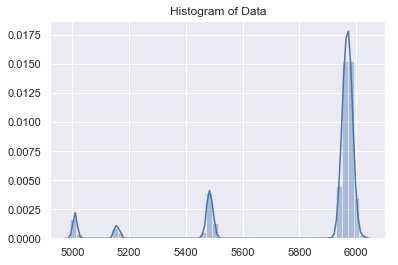

Means:  [5009.84 5158.51 5485.19 5969.24]
SDs:  [ 6.47  7.91  9.95 17.09]
Bins:  [0.   0.04 0.06 0.18 1.  ]
Mixing ratios:  [0.04 0.02 0.12 0.82]

Calculated means:
[5969.69213434 5329.2983743 ]

Initial Values: 
Gaussian 1:	w1:0.5	Mean:5329.3, Standard Deviation:267.51
Gaussian 2:	w2:0.5	Mean:5969.69, Standard Deviation:266.46

Final values at convergence step:  4
Gaussian 1:	w1:0.19	Mean:5332.83, Standard Deviation:211.07
Gaussian 2:	w2:0.81	Mean:5969.7, Standard Deviation:16.7

Final values after all iterations: 
Gaussian 1:	w1:0.19	Mean:5331.36, Standard Deviation:209.07
Gaussian 2:	w2:0.81	Mean:5969.7, Standard Deviation:16.73

Mutual Information with previous Gaussians:
[-0.00449893]

Calculated means:
[5969.69213434 5067.76349706 5484.24130578]

Initial Values: 
Gaussian 1:	w1:0.33	Mean:5067.76, Standard Deviation:268.63
Gaussian 2:	w2:0.33	Mean:5484.24, Standard Deviation:270.84
Gaussian 3:	w3:0.33	Mean:5969.69, Standard Deviation:261.14

Final values at convergence step:  10
G

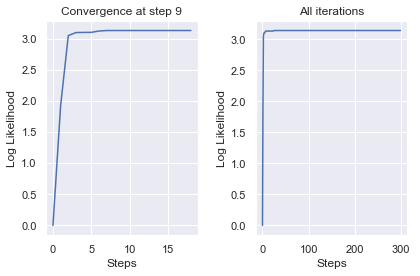

In [11]:
sol = GMM()
sol.estimate_gaussians(n_mixtures=4, samples_pm=500, mean_rng=[0, 6000], sd_rng=[1, 20])